# Image Processing with scikit-image

Some examples to illustrate scikit-image are presented in this notebook.

The code below checks if the package is installed and functioning properly.

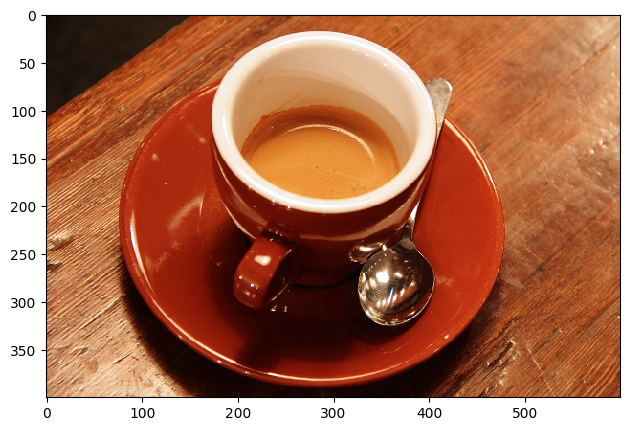

In [1]:
from skimage import data, io
io.imshow(data.coffee())
io.show()

# 1. Detecting Edges and Extracting Regions

In this part of the of the notebook, we follow the paper by Stefan van der Walt, 
Johannes L. Schoenberger, Juan Nunez-Iglesias, 
Francois Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, 
Tony Yu and the scikit-image contributors:
*scikit-image: Image processing in Python.* PeerJ 2:e453 (2014) 

### 1.1 Edge Detection

The ``data`` of ``skimage`` contains a picture of some ancient Roman coins from Pompeii, obtained from the Brooklyn museum.  The Sobel filter will be applied to detect the edges.

In [2]:
from skimage import data, filters, io
from matplotlib import pyplot as plt

In [3]:
image = data.coins()
edges = filters.sobel(image)

C:\Users\jan\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:162: UserWarning: The figure layout has changed to tight
  ax.get_figure().tight_layout()


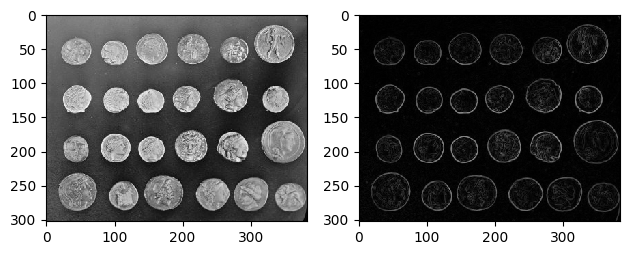

In [4]:
fig = plt.figure()
ax = fig.add_subplot(121)
io.imshow(image)
ax = fig.add_subplot(122)
io.imshow(edges);
io.show()

The Canny edge detector is available in scikit-image.

In [5]:
from skimage import feature

In [6]:
edges = feature.canny(image, sigma=3, low_threshold=10, high_threshold=80)

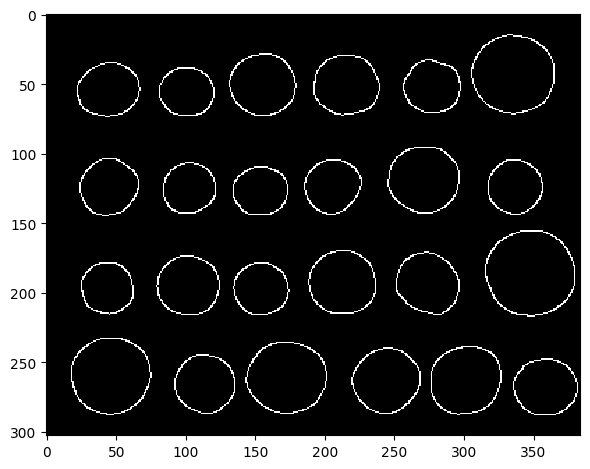

In [7]:
io.imshow(edges, cmap=plt.cm.gray)
io.show()

### 1.2 Intensities, Minima and Maxima

An image is a numpy matrix and we can make a histogram from the intensities of the image.

In [8]:
import numpy as np

In [9]:
image = data.coins()
values, bins = np.histogram(image, bins=np.arange(256))

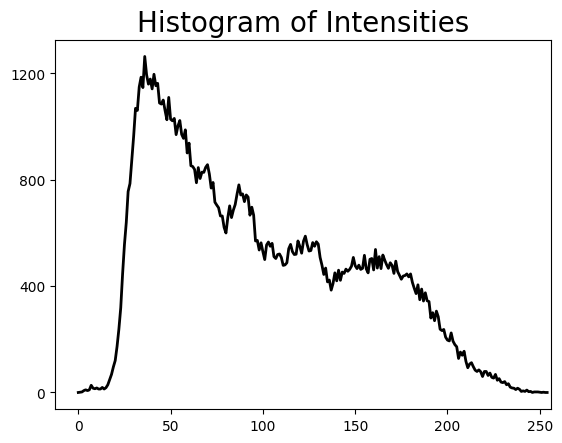

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(bins[:-1], values, lw=2, c='k')
ax.set_xlim(xmax=256)
ax.set_yticks([0, 400, 800, 1200])
# ax.set_aspect(.1)
ax.set_title('Histogram of Intensities', fontsize=20)
plt.show()

Interesting features are the local minima and maxima.

In [11]:
from skimage.feature import peak_local_max

In [12]:
image = data.coins()
coordinates = peak_local_max(image, min_distance=20)

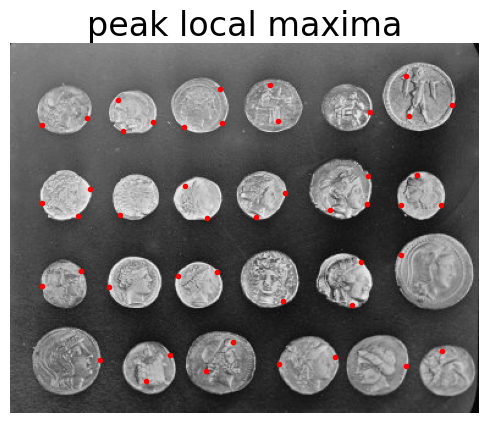

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(image, cmap=plt.cm.gray)
ax.autoscale(False)
ax.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax.set_title('peak local maxima', fontsize=24)
ax.axis('off')
plt.show()

### 1.3 Extracting Regions

To each coin we can attribute a label
and that label can be used to extract a sub picture,
after the application of the Canny edge detector.

In [14]:
from skimage.measure import regionprops
from skimage.morphology import label

In [15]:
image = data.coins()
edges = feature.canny(image, sigma=3, low_threshold=10, high_threshold=80)
label_image = label(edges)

In [16]:
import matplotlib.patches as mpatches

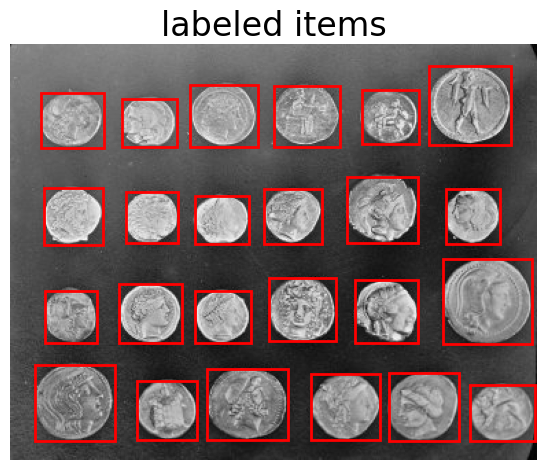

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(image, cmap=plt.cm.gray)
ax.set_title('labeled items', fontsize=24)
ax.axis('off')
for region in regionprops(label_image):
    # Draw rectangle around segmented coins. 
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr),
        maxc - minc, maxr - minr, fill=False,
        edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

After the region extraction, we can begin to pick up the coins ...

## 2. The Region Adjacency Graph

In this second part of the notebook, we follow Chapter 3 of *Elegant Scipy* by Juan Nunez-Iglesias, Harriet Dashnow and Stefan van der Walt, using a picture from the Berkeley Segmentation Dataset (BSDS).

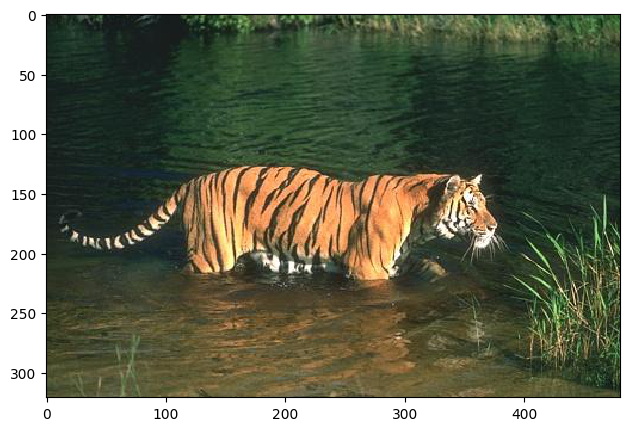

In [18]:
tiger = io.imread('bsdstiger.jpg')
io.imshow(tiger)
io.show()

We want to take the tiger out of this picture.  Let us first have some fun and apply a geometric transformation to the picture.  Let us swirl the tiger around.

In [19]:
from skimage.transform import swirl

In [20]:
swirled = swirl(tiger, strength=6, radius=512)

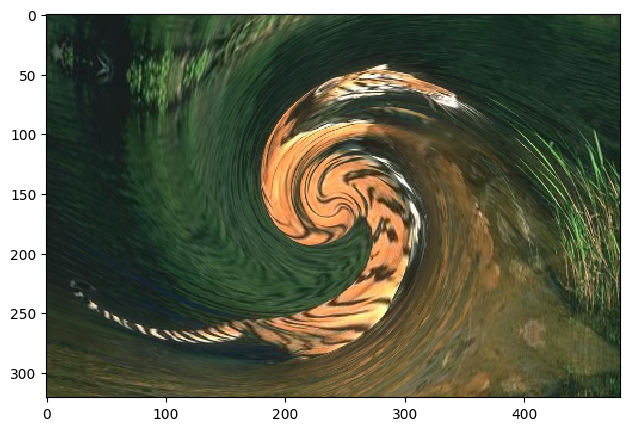

In [21]:
io.imshow(swirled)
io.show()

To segment an image, we apply a clustering algorithm: SLIC, short for Simple Linear Iterative Clustering.

In [22]:
from skimage import segmentation
from skimage import color

In [23]:
seg = segmentation.slic(tiger, n_segments=30, compactness=40.0,
                        enforce_connectivity=True, sigma=3)

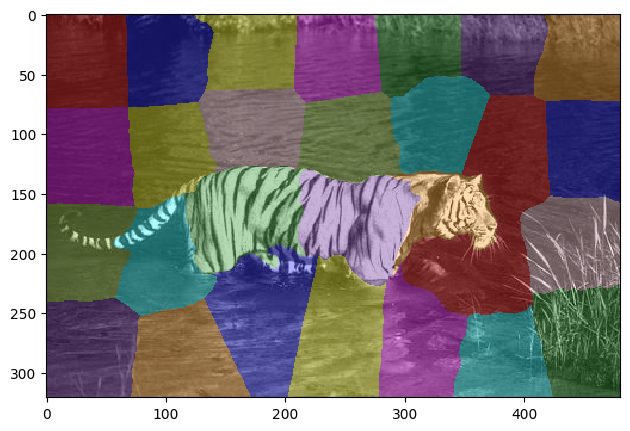

In [24]:
io.imshow(color.label2rgb(seg, tiger))
io.show()

The *Region Adjacency Graph* is a structure to represent the larger regions in an image.

In [25]:
from skimage import graph

In [26]:
G = graph.rag_mean_color(tiger, seg)

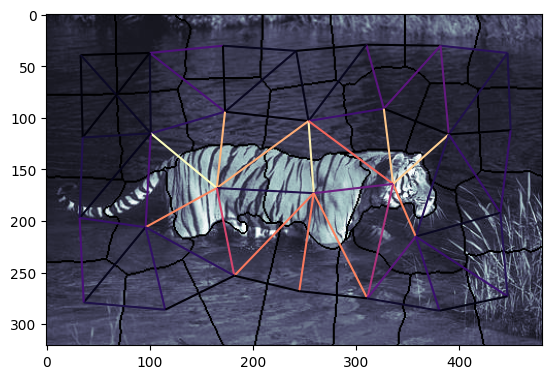

In [27]:
graph.show_rag(seg, G, tiger)
io.show()

Now we are at the stage where we can segment out the tiger from the image.

In [28]:
import networkx as nx

In [29]:
from scipy import ndimage as ndi

In [30]:
def add_edge_filter(values, graph):
    """
    Auxiliary function used in the generic_filter.
    """
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    # float return value is unused but needed by `generic_filter`
    return 0.0

In [31]:
def build_rag(labels, image):
    """
    On input in labels is the output of segmentation.slic
    applied to the image.
    Returned is the region adjacency graph of the image.
    """
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                           mode='nearest', extra_arguments=(g,))
    for n in g:
        g._node[n]['total color'] = np.zeros(3, np.double)
        g._node[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g._node[n]['total color'] += image[index]
        g._node[n]['pixel count'] += 1
    return g

In [32]:
def threshold_graph(g, t):
    """
    Edges in the graph with weight higher than t
    are removed from the graph.
    """
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)

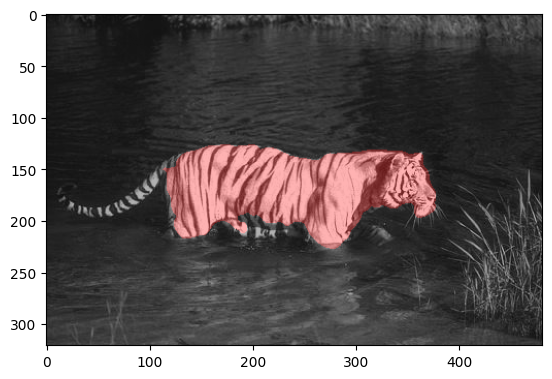

In [33]:
def main():
    """
    Does mean color segmentation.
    """
    tiger = io.imread('bsdstiger.jpg')
    seg = segmentation.slic(tiger, n_segments=30, compactness=40.0,
                            enforce_connectivity=True, sigma=3)
    g = build_rag(seg, tiger)
    for n in g:
        node = g._node[n]
        node['mean'] = node['total color'] / node['pixel count']
    for u, v in g.edges():
        d = g._node[u]['mean'] - g._node[v]['mean']
        g[u][v]['weight'] = np.linalg.norm(d)
    # every edge holds the difference between 
    # the average color in each segment
    threshold_graph(g, 80)
    map_array = np.zeros(np.max(seg) + 1, int)
    for i, segment in enumerate(nx.connected_components(g)):
        for initial in segment:
            map_array[int(initial)] = i
    segmented = map_array[seg]
    plt.imshow(color.label2rgb(segmented, tiger));
    plt.show()

main()